In [42]:
using ForwardDiff
using Plots

In [43]:
## Simple Pendulum
n = 2 # number of states 
m = 1 # number of controls

#initial and goal conditions
x0 = [0.; 0.]
xf = [pi; 0.] # (ie, swing up)

#costs
Q = 0.3*eye(n)
Qf = 30.0*eye(n)
R = 0.3*eye(m)

#simulation
dt = 0.1
tf = 5.

5.0

In [44]:
# Dynamics 
function fc(x,u)
    # continuous dynamics (as defined in https://github.com/HarvardAgileRoboticsLab/unscented-dynamic-programming/blob/master/pendulum_dynamics.m)
    m = 1.
    l = 0.5
    b = 0.1
    lc = 0.5
    I = 0.25
    g = 9.81
    return [x[2]; (u - m*g*lc*sin(x[1]) - b*x[2])];
end

function f(x,u1,u2,du,dt)
    # RK4
    k1 = dt*fc(x,u1+du)
    k2 = dt*fc(x + k1/2,(u1+u2)/2 + du)
    k3 = dt*fc(x + k2/2,(u1+u2)/2 + du)
    k4 = dt*fc(x + k3, u2 + du)
    return x + (k1 + 2*k2 + 2*k3 + k4)/6
end

function fc_aug(x)
    # augmented continuous dynamics
    m = 1.
    l = 0.5
    b = 0.1
    lc = 0.5
    I = 0.25
    g = 9.81
    return [x[2]; (x[3] - m*g*lc*sin(x[1]) - b*x[2]); 0.0; 0.0]; # xd, xdd, u, dt
end

function f2_aug(x)
    # RK4
    #x[3] = x[4] + x[6] # u = u1 + du
    k1 = x[end]*fc_aug(x)
    #x[3] = (x[4]+x[5])/x[end] + x[6] # u = (u1+u2)/dt + du
    k2 = x[end]*fc_aug(x + k1/2)
    k3 = x[end]*fc_aug(x + k2/2)
    #x[3] = x[5] + x[6] # u = u2 + du
    k4 = x[end]*fc_aug(x + k3)
    return x + (k1 + 2*k2 + 2*k3 + k4)/6
end

F = x-> ForwardDiff.jacobian(f2_aug,x)

(::#47) (generic function with 1 method)

In [45]:
#iLQR
function rollout(x0,U,f,dt,tf)
    N = convert(Int64,floor(tf/dt))
    X = zeros(size(x0,1),N)
    X[:,1] = x0
    for k = 1:N-1
        if k == N-1
            X[:,k+1] = f(X[:,k],U[:,k],U[:,k],0.0,dt)
        else
            X[:,k+1] = f(X[:,k],U[:,k],U[:,k+1],0.0,dt)
        end
    end
    return X
end

function cost(X,U,Q,R,Qf,xf)
    N = size(X,2)
    J = 0.0
    for k = 1:N-1
      J += 0.5*(X[:,k] - xf)'*Q*(X[:,k] - xf) + 0.5*U[:,k]'*R*U[:,k]
    end
    J += 0.5*(X[:,N] - xf)'*Qf*(X[:,N] - xf)
    return J
end

function backwardpass(X,U,F,Q,R,Qf,xf)
    n, N = size(X)
    m = size(U,1)
    
    S = zeros(n,n,N)
    s = zeros(n,N)
    
    Qx = zeros(n,1,N)
    Qu = zeros(m,1,N)
    Qxx = zeros(n,n,N)
    Quu = zeros(m,m,N)
    Qux = zeros(m,n,N)
    
    K = zeros(m,n,N-1)
    l = zeros(m,N-1)
    
    S[:,:,N] = Qf
    s[:,N] = Qf*(X[:,N] - xf)
    v1 = 0.0
    v2 = 0.0

    mu = 0.0
    k = N-1
    
    while k >= 1
        q = Q*(X[:,k] - xf)
        r = R*(U[:,k])
        F_aug = F([X[:,k];U[:,k];dt])
        fx = F_aug[1:size(X,1),1:size(X,1)]
        fu = F_aug[1:size(X,1),size(X,1)+1:size(X,1)+size(U,1)]
        
        Qx[:,:,k] = q + fx'*s[:,k+1]
        Qu[:,:,k] = r + fu'*s[:,k+1]
        Qxx[:,:,k] = Q + fx'*S[:,:,k+1]*fx
        Quu[:,:,k] = R + fu'*(S[:,:,k+1] + mu*eye(n))*fu
        Qux[:,:,k] = fu'*(S[:,:,k+1] + mu*eye(n))*fx

        # regularization        
        if any(x->x < 0.0, (eigvals(Quu[:,:,k])))
            mu = mu + 1.0;
            k = N-1;
            println("regularized")
        end
        
        K[:,:,k] = Quu[:,:,k]\Qux[:,:,k]
        l[:,k] = Quu[:,:,k]\Qu[:,:,k]
        s[:,k] = (Qx[:,:,k]' - Qu[:,:,k]'*K[:,:,k] + l[:,k]'*Quu[:,:,k]*K[:,:,k] - l[:,k]'*Qux[:,:,k])'
        S[:,:,k] = Qxx[:,:,k] + K[:,:,k]'*Quu[:,:,k]*K[:,:,k] - K[:,:,k]'*Qux[:,:,k] - Qux[:,:,k]'*K[:,:,k]

        # terms for line search
        v1 += l[:,k]'*Qu[:,:,k]
        v2 += l[:,k]'*Quu[:,:,k]*l[:,k]
        
        k = k - 1;
    end
    return K, l, v1, v2
end

function forwardpass(X,U,f,J,K,l,v1,v2,c1=0.5,c2=0.85)
    N = size(X,2)
    m = size(U,1)
    X_prev = copy(X)
    J_prev = copy(J)
    du = zeros(m,N-1)
    J = Inf
    dV = 0.0
    dJ = 0.0
    z = 0.0
    
    alpha = 1.0
    iter = 0
    max_iter = 20
    while J > J_prev || z < c1 || z > c2 
        if iter > max_iter
            println("Problem")
            println("u: \n $(U+du)")
            break
        end
        for k = 1:N-1
            du[:,k] = -K[:,:,k]*(X[:,k] - X_prev[:,k]) - alpha*l[:,k]
            if k == N-1
                X[:,k+1] = f(X[:,k],U[:,k],U[:,k],du[:,k],dt)
            else
                X[:,k+1] = f(X[:,k],U[:,k],U[:,k+1],du[:,k],dt)
            end
        end

        J = cost(X,U + du,Q,R,Qf,xf)
        
        dV = alpha*v1 + (alpha^2)*v2/2.0
        dJ = J_prev - J
        z = dJ/dV[1]

        alpha = alpha/2.0;
        iter += 1
    end

    println("New cost: $J")
    println("- Expected improvement: $(dV[1])")
    println("- Actual improvement: $(dJ)")
    println("- (z = $z)\n")
    
    return X, copy(U + du), J
end

function solve(x0,m,f,F,Q,R,Qf,xf,dt,tf,iterations=100,eps=1e-5;control_init="random")
    N = convert(Int64,floor(tf/dt))
    X = zeros(size(x0,1),N)
    
    if control_init == "random"
        U = 10.0*rand(m,N-1)
        println("initial control: random")
    else
        U = zeros(m,N-1)
    end
        
    X = rollout(x0,U,f,dt,tf)
    J_prev = cost(X,U,Q,R,Qf,xf)
    println("Initial Cost: $J_prev\n")
    
    for i = 1:iterations
        println("*** Iteration: $i ***")
        K, l, v1, v2 = backwardpass(X,U,F,Q,R,Qf,xf)
        X, U, J = forwardpass(X,U,f,J_prev,K,l,v1,v2)

        if abs(J-J_prev) < eps
          println("-----SOLVED-----")
          println("eps criteria met at iteration: $i")
          break
        end
        J_prev = copy(J)
    end
    
    return X, U
end

solve (generic function with 3 methods)

In [46]:
X, U = solve(x0,m,f,F,Q,R,Qf,xf,dt,tf,control_init="random");

initial control: random
Initial Cost: 42687.34415401852

*** Iteration: 1 ***
New cost: 11836.625461285757
- Expected improvement: 53043.444150663425
- Actual improvement: 30850.718692732764
- (z = 0.5816122837933575)

*** Iteration: 2 ***
New cost: 2654.1267630516627
- Expected improvement: 14441.643547618007
- Actual improvement: 9182.498698234094
- (z = 0.6358347419361869)

*** Iteration: 3 ***
New cost: 1956.5009673238362
- Expected improvement: 1286.3526439729349
- Actual improvement: 697.6257957278265
- (z = 0.5423285745137433)

*** Iteration: 4 ***
New cost: 605.3986251673062
- Expected improvement: 2165.302711122915
- Actual improvement: 1351.10234215653
- (z = 0.6239785020431879)

*** Iteration: 5 ***
New cost: 510.284081587772
- Expected improvement: 171.073494143755
- Actual improvement: 95.11454357953426
- (z = 0.5559864434615945)

*** Iteration: 6 ***
New cost: 391.6510254093878
- Expected improvement: 213.92477229057573
- Actual improvement: 118.63305617838421
- (z = 0.55

Problem
u: 
 [5.70952 6.20468 6.49126 6.55286 6.38879 6.02002 5.48947 4.85465 4.1753 3.50189 2.8692 2.29567 1.78645 1.3376 0.939895 0.581563 0.250036 -0.0669453 -0.380502 -0.699704 -1.03026 -1.3727 -1.72037 -2.05817 -2.36383 -2.61317 -2.78842 -2.8859 -2.91819 -2.90965 -2.88828 -2.87829 -2.89548 -2.9451 -3.02102 -3.10574 -3.17187 -3.18649 -3.11918 -2.95145 -2.68286 -2.32965 -1.91659 -1.46701 -0.995874 -0.507178 0.00552363 0.557538 1.17162]
New cost: 168.1409711513095
- Expected improvement: 2.163699211187159e-9
- Actual improvement: -0.03825612549911739
- (z = -1.768088896151483e7)

*** Iteration: 34 ***
Problem
u: 
 [5.70952 6.20467 6.49123 6.55279 6.38867 6.01984 5.48924 4.85441 4.17509 3.50176 2.86917 2.29573 1.78656 1.33774 0.940036 0.581689 0.25014 -0.0668622 -0.380437 -0.699652 -1.03022 -1.37267 -1.72034 -2.05814 -2.3638 -2.61313 -2.78838 -2.88585 -2.91816 -2.90964 -2.88829 -2.87833 -2.89554 -2.94517 -3.02111 -3.10584 -3.17197 -3.18659 -3.11925 -2.95148 -2.68285 -2.32964 -1.91662 

Problem
u: 
 [5.74301 6.23429 6.51567 6.57097 6.39997 6.02426 5.48751 4.84778 4.16506 3.48972 2.85621 2.28253 1.77346 1.32472 0.926868 0.567963 0.235332 -0.0833353 -0.399143 -0.721028 -1.05439 -1.39923 -1.74807 -2.08494 -2.38694 -2.62995 -2.7972 -2.88668 -2.91259 -2.90023 -2.87772 -2.86876 -2.88833 -2.94077 -3.01903 -3.10475 -3.16991 -3.18146 -3.10962 -2.9372 -2.66524 -2.31098 -1.89937 -1.45327 -0.986938 -0.503808 0.00287669 0.548452 1.15546]
New cost: 168.19319494593498
- Expected improvement: 4.9106563799992064e-11
- Actual improvement: 9.85821714323265e-5
- (z = 2.0075151630206802e6)

*** Iteration: 53 ***
New cost: 168.19317609031737
- Expected improvement: 3.223217035009831e-5
- Actual improvement: 1.885561761127974e-5
- (z = 0.5849937316188896)

*** Iteration: 54 ***
Problem
u: 
 [5.74406 6.23522 6.51643 6.57154 6.40032 6.0244 5.48746 4.84757 4.16475 3.48935 2.85581 2.28213 1.77305 1.32432 0.926459 0.567536 0.23487 -0.0838498 -0.399728 -0.721696 -1.05515 -1.40005 -1.74893 -2.0857

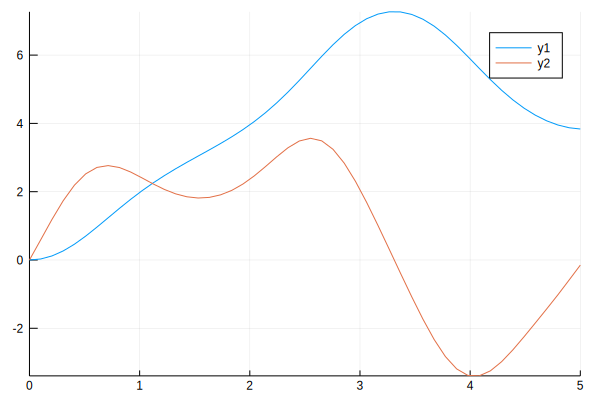

In [47]:
P = plot(linspace(0,tf,size(X,2)),X[1,:])
P = plot!(linspace(0,tf,size(X,2)),X[2,:])

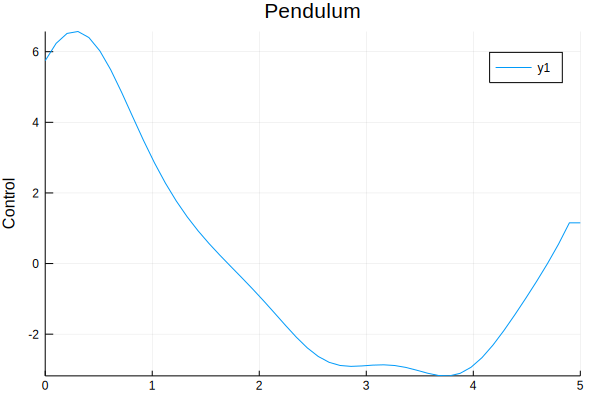

In [48]:
W = plot(linspace(0,tf,size(X,2)),[U[1,:]; U[1,end]],title="Pendulum",ylabel="Control")

In [49]:
plt = plot()
@gif for i=1:size(X,2)
    x = cos(X[1,i] - pi/2)
    y = sin(X[1,i] - pi/2)
    plt = plot([0,x],[0,y],xlims=(-1.5,1.5),ylims=(-1.5,1.5),color="black",size=(200,200),label="",title="Pendulum")
end 

INFO: Saved animation to C:\Users\taylor howell\Google Drive\Stanford\Research-Manchester\iLQR demos\tmp.gif


Plots.AnimatedGif("C:\\Users\\taylor howell\\Google Drive\\Stanford\\Research-Manchester\\iLQR demos\\tmp.gif")